## Initialization

In [1]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment

# Create an experiment with your api key:
experiment = Experiment(
    api_key="lUoLdpDugeusAkGaqqXhj9bZO",
    project_name="thesis-work",
    workspace="tama-ts",
)

     |████████████████████████████████| 276kB 7.6MB/s 
     |████████████████████████████████| 532kB 49.7MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/tama-ts/thesis-work/17550bfee18d4e649820eadb1309ed85



In [2]:
import os
import numpy as np
import torch
from scipy import ndimage
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import gensim
from gensim import corpora

from sklearn.feature_extraction.image import extract_patches #alternative pathes

In [3]:
# Percentile: higher values lead to skipping more pixels (from 0 to 1 - quantile, from 0 to 100 percentile)
quan = 0.5
# use tfidf modeling
tfidf = True
# log of intensities
log = False
#  square root of intensities
sqrt = False 
# hotspot removal
hotspot = False
# median filter window size
med_win = 3

In [4]:
direct = '/content/drive/My Drive/gs_imgs/'
datasets = [direct + i + '/' for i in os.listdir(direct) ]
n_datas = len(datasets)

In [5]:
n_datas

257

In [6]:
files = np.array([datasets[i] + os.listdir(datasets[i])[j] for i in range(n_datas) for j in range(len(os.listdir(datasets[i])))])

In [7]:
# chem_names = [i[i.rfind('/')+1:-4] for i in files]
# print(len(chem_names), len(set(chem_names)))

In [8]:


ch_n = []
for i in range(n_datas):
  ch_n.append(len(os.listdir(datasets[i])))

In [9]:
set(ch_n)

{6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 25,
 26,
 28,
 31,
 32,
 33,
 35,
 39,
 40}

In [10]:
n_files = len(files)
print(n_files)

3188


In [11]:
files[:10]

array(['/content/drive/My Drive/gs_imgs/2018-09-19_09h15m47s/C14H8O6_+Na.npy',
       '/content/drive/My Drive/gs_imgs/2018-09-19_09h15m47s/C14H8O6_+H.npy',
       '/content/drive/My Drive/gs_imgs/2018-09-19_09h15m47s/C15H12O7_+Na.npy',
       '/content/drive/My Drive/gs_imgs/2018-09-19_09h15m47s/C15H10O6_+Na.npy',
       '/content/drive/My Drive/gs_imgs/2018-09-19_09h15m47s/C15H12O7_+K.npy',
       '/content/drive/My Drive/gs_imgs/2018-09-19_09h15m47s/C14H8O6_+K.npy',
       '/content/drive/My Drive/gs_imgs/2018-09-19_09h15m47s/C15H10O6_+K.npy',
       '/content/drive/My Drive/gs_imgs/2017-01-26_09h00m05s/C41H78NO7P_-H.npy',
       '/content/drive/My Drive/gs_imgs/2017-01-26_09h00m05s/C44H84NO10P_-H.npy',
       '/content/drive/My Drive/gs_imgs/2017-01-26_09h00m05s/C45H88NO7P_-H.npy'],
      dtype='<U76')

In [12]:
imgs = [np.load(i) for i in files[:1000]]

In [13]:
plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

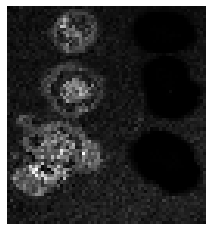

In [39]:
plt.imshow(imgs[888])
plt.axis('off')
plt.show()

In [14]:
shapes = [i.shape for i in imgs]

In [ ]:
len(set(shapes))

220

In [ ]:
#set(shapes)

In [ ]:
for img in imgs:
  # if log: img = np.log(img)
  # if sqrt: img = np.sqrt(img)

  # # remove hot spots
  # if hotspot:
  #     q = np.quantile(img, 0.99)
  #     img[img>q] = q

  # compute intensity threshold
  if quan > 0:
      q = np.quantile(img, quan)
      img[img<q] = 0

  # median filter
  if med_win > 0: 
      img = ndimage.median_filter(img, med_win)

In [ ]:
a = 0
patches_tensor = []
shapes_list = []

kh, kw = 16, 16  # kernel size
dh, dw = 16, 16  # stride

for i in range(n_datas):
  t_img = torch.Tensor(imgs[a: a + ch_n[i]]).unsqueeze(0)
  kc = t_img.shape[1]
  dc = kc

  patches = t_img.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
  unfold_shape = patches.size()
  shapes_list.append(unfold_shape)
  patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)

  a += ch_n[i]
  #patches_tensor.append(patches.squeeze(0))
  patches_tensor.append(patches.reshape(-1, kh, kw))

In [ ]:
p_t = [patches_tensor[i][j] for i in range(len(patches_tensor)) for j in range(len(patches_tensor[i]))]

In [ ]:
len(p_t)

187743

In [ ]:
p_t = torch.cat(p_t)

In [ ]:
p_t = p_t.view(-1, 16, 16)

In [ ]:
p_t.shape

torch.Size([187743, 16, 16])

In [ ]:
X_train = p_t

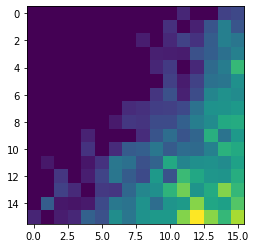

In [ ]:
plt.imshow(X_train[70000])

In [ ]:
patches_tensor[2].shape

torch.Size([616, 16, 16])

In [ ]:
orig_images = []
for i in range(len(shapes_list)):
  patches = patches_tensor[i]
  unfold_shape = shapes_list[i]

  patches_orig = patches.view(unfold_shape)
  output_c = unfold_shape[1] * unfold_shape[4]
  output_h = unfold_shape[2] * unfold_shape[5]
  output_w = unfold_shape[3] * unfold_shape[6]
  patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
  patches_orig = patches_orig.view(1, output_c, output_h, output_w)

  orig_images.append(patches_orig)

In [ ]:
imgs[0].shape

(90, 95)

In [ ]:
orig_images[0].shape

torch.Size([1, 7, 80, 80])

In [ ]:
np.sum(ch_n[:10])

100

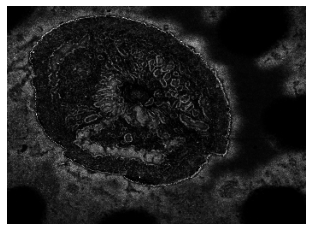

In [29]:
plt.imshow(imgs[999])
plt.axis('off')
plt.show()

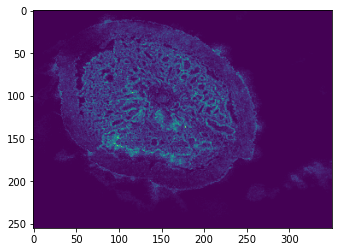

In [ ]:
plt.imshow(imgs[1000])

In [ ]:
imgs[100].shape

(50, 50)

# Linear - FAE

### Ordinary

In [ ]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=1000, shuffle=True)

In [ ]:
dimZ = 16 # size of the bottleneck

class FAE(nn.Module):
    def __init__(self, bottleneck = dimZ):
        super(FAE, self).__init__()
        
        self.bottleneck = bottleneck
        def init_weights(m):
          if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
            m.bias.data.fill_(0)

        self.encoder = nn.Sequential(nn.Linear(16*16, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, self.bottleneck), nn.ReLU())
        self.encoder.apply(init_weights)

        self.decoder = nn.Sequential(nn.Linear(self.bottleneck, 64), nn.ReLU(), nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 16*16), nn.Sigmoid())
        self.decoder.apply(init_weights)

        
    def forward(self, x):
        
        latent_code = self.encoder(x.view(-1,16*16)) 
  
        reconstruction = self.decoder(latent_code).view(-1, 16,16)
        
        return reconstruction, latent_code

In [ ]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = FAE().cuda()

optimizer = torch.optim.SGD(autoencoder.parameters(), lr = 0.00001, momentum = 0.1, dampening = 0, nesterov=True) #optim.Adam(autoencoder.parameters(), lr = 0.001)

In [ ]:
n_epochs = 20

In [ ]:
experiment.set_name("FAE, 4 layer")

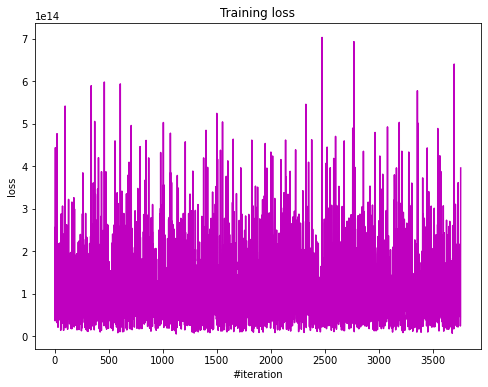

[Epoch 20/20] [Batch 188/100] [Loss: 396129933983744.000000]


In [ ]:
losses = []
image_progress = []
for epoch in range(n_epochs):
  i = 0
  for X, y in train_loader:
    i += 1
    optimizer.zero_grad()
    X = X.cuda()
    out_reconstr, out_latent = autoencoder.forward(X)
    loss = criterion(out_reconstr, X)
    loss.backward()
    losses.append(loss.detach())
    optimizer.step()

    experiment.log_epoch_end(epoch)
    experiment.log_metric("train_mse_loss", loss.detach())
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    


    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(losses, 'm')
    plt.show()            
    print(
        "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
        % (epoch+1, n_epochs, i, 100, loss.item()))

In [ ]:
torch.save(autoencoder.state_dict(), "/content/drive/My Drive/weights/fae4.pth")

### Variational

In [ ]:
X_train_norm = X_train/X_train.max()

In [ ]:
train = data_utils.TensorDataset(torch.Tensor(X_train_norm), torch.zeros(X_train_norm.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=1000, shuffle=True)

In [ ]:
class FVAE(nn.Module):
    def __init__(self):
        super(FVAE, self).__init__()
        
        def init_weights(m):
          if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight, gain=0.1)
            m.bias.data.fill_(0)

        self.encoder_1 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(),
                                     nn.Linear(64, 32), nn.ReLU())#, nn.Linear(1000, self.bottleneck), nn.ReLU())
        self.encoder_21 = nn.Linear(32, 16)
        self.encoder_22 = nn.Linear(32, 16)
        # self.encoder_1.apply(init_weights)
        # self.encoder_21.apply(init_weights)
        # self.encoder_22.apply(init_weights)

        self.decoder = nn.Sequential(nn.Linear(16, 32), nn.ReLU(), nn.Linear(32, 64), nn.ReLU(), 
                                     nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 256), nn.Sigmoid())
        # self.decoder.apply(init_weights)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        
        x_out = self.encoder_1(x)
        mu, logvar = self.encoder_21(x_out), self.encoder_22(x_out)
        z = self.reparameterize(mu, logvar)

        return self.decoder(z), mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
model = FVAE().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.00001, momentum = 0.1, dampening = 0, nesterov=True) #optim.Adam(autoencoder.parameters(), lr = 0.001)

In [ ]:
n_epochs = 20

In [ ]:
experiment.set_name("FVAE, 4, normed filtered")

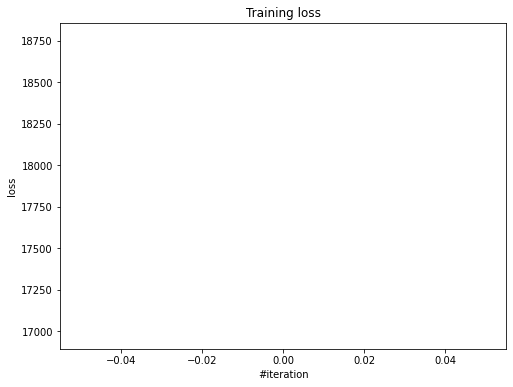

[Epoch 10/20] [Batch 15/100] [Loss: 992.880310]


In [ ]:
losses = []
image_progress = []
for epoch in range(n_epochs):
  i = 0
  train_loss = 0
  for X, y in train_loader:
    i += 1
    optimizer.zero_grad()
    X = X.view(-1,256).cuda()
    recon_batch, mu, logvar = model(X)
    loss = loss_function(recon_batch, X, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

    experiment.log_epoch_end(epoch)
    experiment.log_metric("train_mse_loss", loss.detach())
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    


    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss, 'm')
    plt.show()            
    print(
        "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
        % (epoch+1, n_epochs, i, 100, loss.item()))

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/weights/fvae_normed.pth")

In [ ]:
out = model(X_train_norm[0].view(-1,256).cuda())

In [ ]:
X_train_norm[0]

tensor([[0.0000, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.0003,
         0.0003, 0.0003, 0.0002, 0.0000, 0.0002, 0.0000, 0.0002],
        [0.0000, 0.0000, 0.0003, 0.0002, 0.0002, 0.0002, 0.0003, 0.0000, 0.0002,
         0.0002, 0.0000, 0.0002, 0.0002, 0.0004, 0.0004, 0.0003],
        [0.0000, 0.0000, 0.0003, 0.0002, 0.0000, 0.0003, 0.0003, 0.0003, 0.0002,
         0.0003, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0003, 0.0000, 0.0002, 0.0002, 0.0003, 0.0002, 0.0002,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0002, 0.0002, 0.0002, 0.0002, 0.0004, 0.0002, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0002, 0.0003, 0.0003, 0.0003, 0.0002, 0.0003, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0002, 0.0000, 0.0000, 0.0002, 0.0002],
        [0.0002, 0.0003, 0.0002, 0.0002, 0.0002, 0.0003, 0.0002, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.00

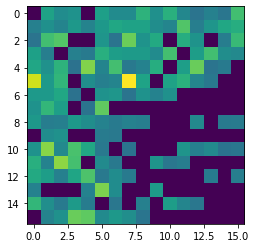

In [ ]:
plt.imshow(X_train_norm[100].numpy())

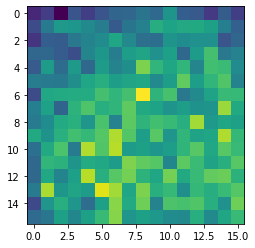

In [ ]:
out = model(X_train_norm[100].view(-1,256).cuda())
plt.imshow(out[0].cpu().view(16,16).detach().numpy())

In [ ]:
torch.save(model.state_dict(), "weights_fvae_filtered_data.pth")

# Convolutional

## 1D patch based CAE

In [ ]:
X_train_norm = X_train

In [ ]:
X_train_norm.shape

torch.Size([187743, 16, 16])

In [ ]:
X_train_norm = X_train_norm.unsqueeze(1)

In [ ]:
train = data_utils.TensorDataset(torch.Tensor(X_train_norm), torch.zeros(X_train_norm.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=1000, shuffle=True)

In [ ]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        # self.conv1 = self.conv_layer_set(1, 2)
        # self.conv2 = self.conv_layer_set(2, 4)

        # self.conv3 = self.conv_layer_set(1, 2)
        # self.conv4 = self.conv_layer_set(2, 4)



        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)



    def conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=(3, 3, 3), padding=1))
        #nn.LeakyReLU(),
        #nn.MaxPool3d((2, 2, 2)))
        return conv_layer

    def forward(self, x):
        enc = self.conv1(x)
        enc = self.pool(F.relu(enc))
        enc = self.conv2(enc)
        enc = self.pool(F.relu(enc))

        dec = F.relu(self.t_conv1(enc))
        dec = torch.sigmoid(self.t_conv2(dec))

        return dec, enc

In [ ]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = CAE().cuda()

optimizer = torch.optim.SGD(autoencoder.parameters(), lr = 0.00001, momentum = 0.1, dampening = 0, nesterov=True) #optim.Adam(autoencoder.parameters(), lr = 0.001)

RuntimeError: ignored

In [ ]:
n_epochs = 20

In [ ]:
experiment.set_name("CAE, 2 layer, 1-16-4")

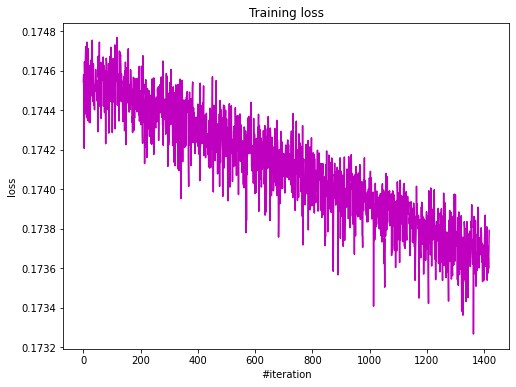

[Epoch 8/20] [Batch 103/100] [Loss: 0.173791]


In [ ]:
losses = []
image_progress = []
for epoch in range(n_epochs):
  i = 0
  for X, y in train_loader:
    i += 1
    optimizer.zero_grad()
    X = X.cuda()
    out_reconstr, out_latent = autoencoder.forward(X)
    loss = criterion(out_reconstr, X)
    loss.backward()
    losses.append(loss.detach())
    optimizer.step()

    experiment.log_epoch_end(epoch)
    experiment.log_metric("train_mse_loss", loss.detach())
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    


    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(losses, 'm')
    plt.show()            
    print(
        "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
        % (epoch+1, n_epochs, i, 100, loss.item()))

In [ ]:
torch.save(autoencoder.state_dict(), "weights_cae_filtered_data.pth")

In [ ]:
out1 = cae.(X_train[0].unsqueeze(0).unsqueeze(0))

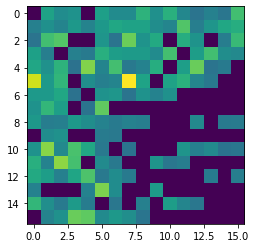

In [ ]:
plt.imshow(X_train[100].numpy())

In [ ]:
X_train_norm[100].shape

torch.Size([1, 16, 16])

In [ ]:
out = autoencoder(X_train_norm[100].unsqueeze(0).cuda())

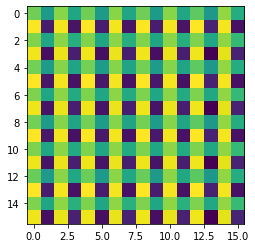

In [ ]:
plt.imshow(out[0][0][0].cpu().detach().numpy())

## CVAE

In [ ]:
X_train_norm = X_train/X_train.max()

In [ ]:
X_train_norm = X_train_norm.unsqueeze(1)

In [ ]:
train = data_utils.TensorDataset(torch.Tensor(X_train_norm), torch.zeros(X_train_norm.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=1000, shuffle=True)

In [ ]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        kernel_size = 4 # (4, 4) kernel
        init_channels = 8 # initial number of filters
        image_channels = 1 # MNIST images are grayscale
        latent_dim = 16 # latent dimension for sampling
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=2, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=2, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var, z

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
autoencoder = ConvVAE().cuda()

optimizer = torch.optim.SGD(autoencoder.parameters(), lr = 0.00001, momentum = 0.1, dampening = 0, nesterov=True) #optim.Adam(autoencoder.parameters(), lr = 0.001)

In [ ]:
n_epochs = 20

In [ ]:
experiment.set_name("CVAE, 1")

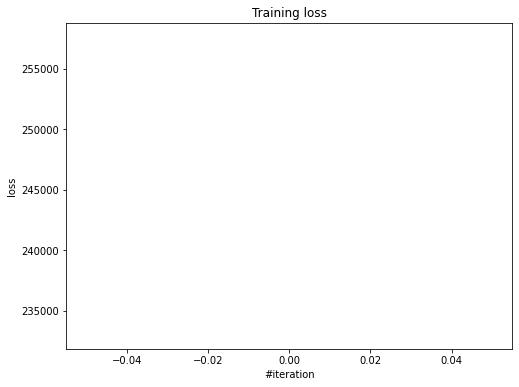

[Epoch 20/20] [Batch 188/100] [Loss: 1023.454407]


In [ ]:
losses = []
image_progress = []
for epoch in range(n_epochs):
  i = 0
  train_loss = 0
  for X, y in train_loader:
    i += 1
    optimizer.zero_grad()
    X = X.cuda()
    recon_batch, mu, logvar = autoencoder(X)
    loss = loss_function(recon_batch, X, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

    experiment.log_epoch_end(epoch)
    experiment.log_metric("train_mse_loss", loss.detach())
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    


    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss, 'm')
    plt.show()            
    print(
        "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
        % (epoch+1, n_epochs, i, 100, loss.item()))

In [ ]:
torch.save(autoencoder.state_dict(), "/content/drive/My Drive/weights/cvae_normed_data.pth")

In [ ]:
autoencoder.load_state_dict(torch.load("/content/drive/My Drive/weights/cvae_normed_data.pth"))

<All keys matched successfully>

In [ ]:
autoencoder.eval()

ConvVAE(
  (enc1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc4): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=16, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=64, bias=True)
  (dec1): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (dec2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [ ]:
patches_tensor[0].shape

torch.Size([175, 16, 16])

In [ ]:
out = autoencoder(X_train_norm.cuda())[3]#.squeeze(1)

In [ ]:
ch_n[0]

7

In [ ]:
len(patches_tensor[0])

175

In [ ]:
patches_tensor[1].shape

In [ ]:
0:25

In [ ]:
a = 0
cut = out[a: a+len(patches_tensor[0])]
one_image = [cut[k:k+25] for k in range(ch_n[0])]

In [ ]:
one_image[7].shape

IndexError: ignored

In [ ]:
a = 0
latent_tensor = []
for i in range(len(patches_tensor)):
  cut = out[a: a+len(patches_tensor[i])]
  one_image = [cut[k:k+25] for k in range(ch_n[i])]
  latent_tensor.append(one_image)
  a += len(patches_tensor[i])

In [ ]:
len(one_image)

10

In [ ]:
cos = nn.CosineSimilarity(dim=0)

In [ ]:
len(latent_tensor[50])

11

In [ ]:
imgs[0].flatten().shape

(8550,)

In [ ]:
cos(latent_tensor[0][0][0], latent_tensor[0][0][1])

tensor([[-0.2914]], device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
len(latent_tensor[0][0])

25

In [ ]:
corrs = []
for lat in latent_tensor:
  for i in lat:
    for j in i:
      corr = [cos(k, j) for k in j]
      corrs.append(corr)

In [ ]:
len(corrs)

NameError: ignored

In [ ]:
#for i in range(len(latent_tensor)):
for j in range(len(latent_tensor[0])):
  corr = [cos()]
  for k in range(len(latent_tensor[0])):
    corr.append()

9

In [ ]:
orig_images = []
for i in range(len(shapes_list)):
  patches = out_images[i]
  unfold_shape = shapes_list[i]

  patches_orig = patches.view(unfold_shape)
  output_c = unfold_shape[1] * unfold_shape[4]
  output_h = unfold_shape[2] * unfold_shape[5]
  output_w = unfold_shape[3] * unfold_shape[6]
  patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
  patches_orig = patches_orig.view(1, output_c, output_h, output_w)
   
  orig_images.append(patches_orig)

In [ ]:
len(orig_images)

257

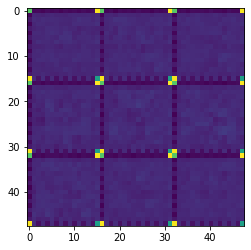

In [ ]:
plt.imshow(orig_images[100][0][6].detach().numpy())

In [ ]:
for i in range(len(patch_tensor)):
  first_run = True
  counter = 0
  ion_corpus = []
  img = imgs[0]

  x = img.flatten()

  if first_run:
      int_df = pd.DataFrame(columns = list(range(0, x.shape[0])))
      first_run = False

In [ ]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)

NameError: ignored

## CAE for unpatched images

In [ ]:
a = 0
patches_tensor_whole = []

for i in range(n_datas):

  patches = torch.Tensor(imgs[a: a + ch_n[i]]).unsqueeze(0)

  a += ch_n[i]
  patches_tensor_whole.append(patches)

In [ ]:
from torch.utils.data.dataset import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, imgs):
        self.imgs = imgs
        
    def __getitem__(self, index):
        img = self.imgs[index]
        return img

    def __len__(self):
      count = len(self.imgs)
      return count # of how many examples(images?) you have

In [ ]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        # self.conv1 = self.conv_layer_set(1, 2)
        # self.conv2 = self.conv_layer_set(2, 4)

        # self.conv3 = self.conv_layer_set(1, 2)
        # self.conv4 = self.conv_layer_set(2, 4)



        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv3d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv3d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool3d(2, 2)

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose3d(4, 16, 3, padding=1)
        self.t_conv2 = nn.ConvTranspose3d(16, 1, 3, padding=1)



    def conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=(3, 3, 3), padding=1))
        #nn.LeakyReLU(),
        #nn.MaxPool3d((2, 2, 2)))
        return conv_layer

    def forward(self, x):

        print(x.shape)

        enc = self.conv1(x)
        enc = self.pool(F.relu(enc))
        print(enc.shape)

        enc = self.conv2(enc)
        enc = self.pool(F.relu(enc))
        print(enc.shape)

        dec = F.relu(self.t_conv1(enc))
        print(dec.shape)
        dec = torch.sigmoid(self.t_conv2(dec))
        print(dec.shape)

        return dec, enc

In [ ]:
x = MyCustomDataset(patches_tensor_whole)
train_loader = data_utils.DataLoader(x, batch_size=1, shuffle=True)

In [ ]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = CAE().cuda()

optimizer = torch.optim.SGD(autoencoder.parameters(), lr = 0.00001, momentum = 0.1, dampening = 0, nesterov=True) #optim.Adam(autoencoder.parameters(), lr = 0.001)

In [ ]:
n_epochs = 20

In [ ]:
experiment.set_name("CAE, 2 layer, pooling, 1-16-4, patches, whole dataset")

In [ ]:
losses = []
image_progress = []
for epoch in range(n_epochs):
  i = 0
  for X in train_loader:
    i += 1
    optimizer.zero_grad()
    X = X.cuda()
    out_reconstr, out_latent = autoencoder.forward(X)
    loss = criterion(out_reconstr, X)
    loss.backward()
    losses.append(loss.detach())
    optimizer.step()

    experiment.log_epoch_end(epoch)
    experiment.log_metric("train_mse_loss", loss.detach())
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    


    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(losses, 'm')
    plt.show()            
    print(
        "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
        % (epoch+1, n_epochs, i, 100, loss.item()))

torch.Size([1, 1, 10, 101, 185])
torch.Size([1, 16, 5, 50, 92])
torch.Size([1, 4, 2, 25, 46])
torch.Size([1, 16, 2, 25, 46])
torch.Size([1, 1, 2, 25, 46])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([1, 1, 10, 101, 185])) that is different to the input size (torch.Size([1, 1, 2, 25, 46])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



RuntimeError: ignored

In [ ]:
autoencoder.eval()

CAE(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(16, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (t_conv2): ConvTranspose3d(16, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

In [ ]:
out = autoencoder(patches_tensor[106].unsqueeze(0).cuda())

torch.Size([1, 16, 11, 63, 98])
torch.Size([1, 4, 11, 63, 98])
torch.Size([1, 16, 11, 63, 98])
torch.Size([1, 1, 11, 63, 98])


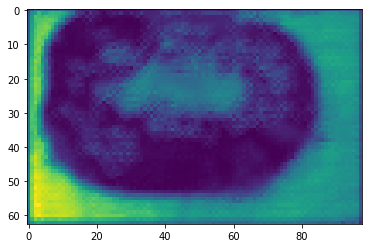

In [ ]:
plt.imshow(out[1][0][3][9].cpu().detach().numpy())

# Top Level

## U-net

In [ ]:
X_train_norm = X_train#/X_train.max()

In [ ]:
X_train_norm = X_train_norm.unsqueeze(1)

In [ ]:
train = data_utils.TensorDataset(torch.Tensor(X_train_norm), torch.zeros(X_train_norm.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=500, shuffle=True)

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        print(x.shape)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        print(x5.shape)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
net = UNet(n_channels = 1, n_classes = 1).cuda()

In [ ]:
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [ ]:
criterion = torch.nn.MSELoss()

In [ ]:
n_epochs = 20

In [ ]:
experiment.set_name("Unet, 8 try, bs = 500")

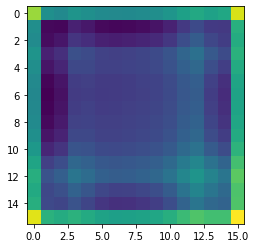

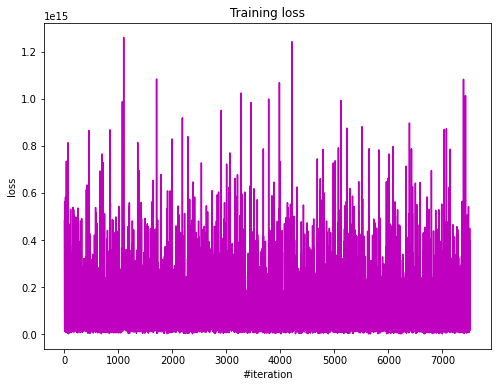

[Epoch 20/20] [Batch 376/376] [Loss: 20648973828096.000000]


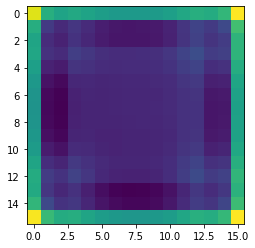

In [ ]:
losses = []
image_progress = []
for epoch in range(n_epochs):
  i = 0
  for X, y in train_loader:
    i += 1
    optimizer.zero_grad()
    X = X.cuda()
    out_reconstr = net.forward(X)
    loss = criterion(out_reconstr, X)
    loss.backward()
    losses.append(loss.detach())
    optimizer.step()

    experiment.log_epoch_end(epoch)
    experiment.log_metric("train_mse_loss", loss.detach())
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    


    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(losses, 'm')
    plt.show()            
    print(
        "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]"
        % (epoch+1, n_epochs, i, 376, loss.item()))
    
    plt.imshow(out_reconstr[222][0].cpu().detach().numpy())

In [ ]:
torch.save(net.state_dict(), "/content/drive/My Drive/weights/weights_unet4_not_normed_data.pth")

In [ ]:
net.load_state_dict(torch.load("/content/drive/My Drive/weights_unet3_not_normed_data.pth"))

<All keys matched successfully>

In [ ]:
net.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

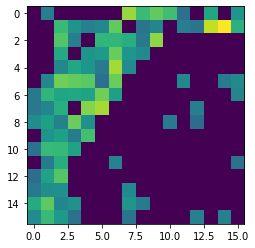

In [ ]:
plt.imshow(X_train[0])

In [ ]:
torch.sum(X_train[5000])

tensor(0.)

In [ ]:
out = net(X_train_norm[:1000].cuda()).squeeze(1)

torch.Size([1000, 1, 16, 16])
torch.Size([1000, 512, 1, 1])


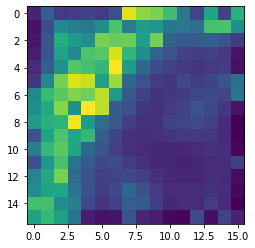

In [ ]:
plt.imshow(out[0].cpu().detach().numpy())

In [ ]:
out.shape

torch.Size([1000, 16, 16])

In [ ]:
p_t.shape

torch.Size([187743, 16, 16])

Reconstructing images

In [ ]:
out_t = [patches_tensor[i][j] for i in range(len(patches_tensor)) for j in range(len(patches_tensor[i]))]

In [ ]:
out_t = torch.zeros_like(patches_tensor[0])

In [ ]:
a = 0
out_images = []
for i in range(len(patches_tensor)):
  image = torch.zeros_like(patches_tensor[i])
  for j in range(len(patches_tensor[i])):
    image[j] = out[a]
    a +=1
  out_images.append(image)

IndexError: ignored

In [ ]:
orig_images = []
for i in range(1):#(len(shapes_list)):
  patches = out_images[i]
  unfold_shape = shapes_list[i]

  patches_orig = patches.view(unfold_shape)
  output_c = unfold_shape[1] * unfold_shape[4]
  output_h = unfold_shape[2] * unfold_shape[5]
  output_w = unfold_shape[3] * unfold_shape[6]
  patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
  patches_orig = patches_orig.view(1, output_c, output_h, output_w)
   
  orig_images.append(patches_orig)

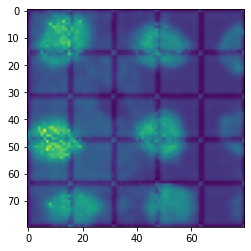

In [ ]:
plt.imshow(orig_images[0][0][5].detach().numpy())

## Sparse experiments

In [ ]:
a = 0
patches_tensor_sparse = []
shapes_list = []

kh, kw = 16, 16  # kernel size
dh, dw = 16, 16  # stride

for i in range(n_datas):
  t_img = torch.Tensor(imgs[a: a + ch_n[i]]).unsqueeze(0)
  kc = t_img.shape[1]
  dc = kc

  patches = t_img.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
  unfold_shape = patches.size()
  shapes_list.append(unfold_shape)
  patches = patches.contiguous().view(kc, -1, kh, kw)

  a += ch_n[i]
  #patches_tensor.append(patches.squeeze(0))
  patches_tensor_sparse.append(patches)

In [ ]:
len(patches_tensor_sparse)

257

In [ ]:
patches.shape

torch.Size([10, 234, 16, 16])

In [ ]:
p_max_n = np.max([i.shape[1] for i in patches_tensor_sparse])

In [ ]:
p_max_n

572

In [ ]:
chem_names = [i[i.rfind('/')+1:-4] for i in files]
chem_names_unique = set(chem_names)

In [ ]:
chem_dict = {k: v for v, k in enumerate(chem_names_unique)}

In [ ]:
indices_all = []

for i in range(len(ch_n)):
  indices_img = []
  for j in range(ch_n[i]):
    indices_img.append([i, chem_dict.get(chem_names[j])])
  indices_all.append(indices_img)

In [ ]:
x, y, z = [], [], []
for a in range(len(patches_tensor_sparse)):
  l = len(indices_all[a])
  k = patches_tensor_sparse[a].shape[1]
  for i in range(l):
    x.append([indices_all[a][i][0]]*k)
    y.append([indices_all[a][i][1]]*k)
    z.append(list(np.arange(k)))

In [ ]:
import itertools

x = list(itertools.chain(*x))
y = list(itertools.chain(*y))
z = list(itertools.chain(*z))

In [ ]:
ppp = [i.view(-1, 16, 16) for i in patches_tensor_sparse]
now =  torch.cat(ppp)

In [ ]:
now.shape

torch.Size([187743, 16, 16])

In [ ]:
print("dims=", (len(patches_tensor_sparse), len(chem_dict.keys()), p_max_n, 16, 16))

dims= (257, 1661, 572, 16, 16)


In [ ]:
s = torch.sparse_coo_tensor([x,y,z], now, (len(patches_tensor_sparse), len(chem_dict.keys()), p_max_n, 16, 16))

In [ ]:
s.shape

torch.Size([257, 1661, 572, 16, 16])

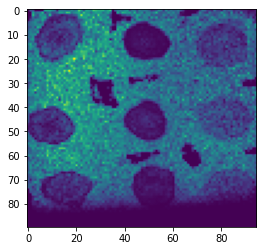

In [ ]:
plt.imshow(imgs[2])

## Depth­wise Spatial Convolutional AE

In [ ]:

import torch
import torch.nn as nn
import torchvision


EPS = 1e-7


class Encoder(nn.Module):
    def __init__(self, cin, cout, nf=64, activation=nn.Tanh):
        super(Encoder, self).__init__()
        network = [
            nn.Conv2d(cin, nf, kernel_size=4, stride=2, padding=1, bias=False),  # 64x64 -> 32x32
            nn.ReLU(inplace=True),
            nn.Conv2d(nf, nf*2, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32 -> 16x16
            nn.ReLU(inplace=True),
            nn.Conv2d(nf*2, nf*4, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 -> 8x8
            nn.ReLU(inplace=True),
            nn.Conv2d(nf*4, nf*8, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 -> 4x4
            nn.ReLU(inplace=True),
            nn.Conv2d(nf*8, nf*8, kernel_size=4, stride=1, padding=0, bias=False),  # 4x4 -> 1x1
            nn.ReLU(inplace=True),
            nn.Conv2d(nf*8, cout, kernel_size=1, stride=1, padding=0, bias=False)]
        if activation is not None:
            network += [activation()]
        self.network = nn.Sequential(*network)

    def forward(self, input):
        return self.network(input).reshape(input.size(0),-1)


class EDDeconv(nn.Module):
    def __init__(self, cin, cout, zdim=128, nf=64, activation=nn.Tanh):
        super(EDDeconv, self).__init__()
        ## downsampling
        network = [
            nn.Conv2d(cin, nf, kernel_size=4, stride=2, padding=1, bias=False),  # 64x64 -> 32x32
            nn.GroupNorm(16, nf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf, nf*2, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32 -> 16x16
            nn.GroupNorm(16*2, nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*2, nf*4, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 -> 8x8
            nn.GroupNorm(16*4, nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*4, nf*8, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 -> 4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*8, zdim, kernel_size=4, stride=1, padding=0, bias=False),  # 4x4 -> 1x1
            nn.ReLU(inplace=True)]
        ## upsampling
        network += [
            nn.ConvTranspose2d(zdim, nf*8, kernel_size=4, stride=1, padding=0, bias=False),  # 1x1 -> 4x4
            nn.ReLU(inplace=True),
            nn.Conv2d(nf*8, nf*8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nf*8, nf*4, kernel_size=4, stride=2, padding=1, bias=False),  # 4x4 -> 8x8
            nn.GroupNorm(16*4, nf*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(nf*4, nf*4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(16*4, nf*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nf*4, nf*2, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 -> 16x16
            nn.GroupNorm(16*2, nf*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(nf*2, nf*2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(16*2, nf*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nf*2, nf, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 -> 32x32
            nn.GroupNorm(16, nf),
            nn.ReLU(inplace=True),
            nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(16, nf),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 32x32 -> 64x64
            nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(16, nf),
            nn.ReLU(inplace=True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=False),
            nn.GroupNorm(16, nf),
            nn.ReLU(inplace=True),
            nn.Conv2d(nf, cout, kernel_size=5, stride=1, padding=2, bias=False)]
        if activation is not None:
            network += [activation()]
        self.network = nn.Sequential(*network)

    def forward(self, input):
        return self.network(input)


class ConfNet(nn.Module):
    def __init__(self, cin, cout, zdim=128, nf=64):
        super(ConfNet, self).__init__()
        ## downsampling
        network = [
            nn.Conv2d(cin, nf, kernel_size=4, stride=2, padding=1, bias=False),  # 64x64 -> 32x32
            nn.GroupNorm(16, nf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf, nf*2, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32 -> 16x16
            nn.GroupNorm(16*2, nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*2, nf*4, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 -> 8x8
            nn.GroupNorm(16*4, nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*4, nf*8, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 -> 4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*8, zdim, kernel_size=4, stride=1, padding=0, bias=False),  # 4x4 -> 1x1
            nn.ReLU(inplace=True)]
        ## upsampling
        network += [
            nn.ConvTranspose2d(zdim, nf*8, kernel_size=4, padding=0, bias=False),  # 1x1 -> 4x4
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nf*8, nf*4, kernel_size=4, stride=2, padding=1, bias=False),  # 4x4 -> 8x8
            nn.GroupNorm(16*4, nf*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nf*4, nf*2, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 -> 16x16
            nn.GroupNorm(16*2, nf*2),
            nn.ReLU(inplace=True)]
        self.network = nn.Sequential(*network)

        out_net1 = [
            nn.ConvTranspose2d(nf*2, nf, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 -> 32x32
            nn.GroupNorm(16, nf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nf, nf, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32 -> 64x64
            nn.GroupNorm(16, nf),
            nn.ReLU(inplace=True),
            nn.Conv2d(nf, 2, kernel_size=5, stride=1, padding=2, bias=False),  # 64x64
            nn.Softplus()]
        self.out_net1 = nn.Sequential(*out_net1)

        out_net2 = [nn.Conv2d(nf*2, 2, kernel_size=3, stride=1, padding=1, bias=False),  # 16x16
                    nn.Softplus()]
        self.out_net2 = nn.Sequential(*out_net2)

    def forward(self, input):
        out = self.network(input)
        return self.out_net1(out), self.out_net2(out)


class PerceptualLoss(nn.Module):
    def __init__(self, requires_grad=False):
        super(PerceptualLoss, self).__init__()
        mean_rgb = torch.FloatTensor([0.485, 0.456, 0.406])
        std_rgb = torch.FloatTensor([0.229, 0.224, 0.225])
        self.register_buffer('mean_rgb', mean_rgb)
        self.register_buffer('std_rgb', std_rgb)

        vgg_pretrained_features = torchvision.models.vgg16(pretrained=True).features
        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def normalize(self, x):
        out = x/2 + 0.5
        out = (out - self.mean_rgb.view(1,3,1,1)) / self.std_rgb.view(1,3,1,1)
        return out

    def __call__(self, im1, im2, mask=None, conf_sigma=None):
        im = torch.cat([im1,im2], 0)
        im = self.normalize(im)  # normalize input

        ## compute features
        feats = []
        f = self.slice1(im)
        feats += [torch.chunk(f, 2, dim=0)]
        f = self.slice2(f)
        feats += [torch.chunk(f, 2, dim=0)]
        f = self.slice3(f)
        feats += [torch.chunk(f, 2, dim=0)]
        f = self.slice4(f)
        feats += [torch.chunk(f, 2, dim=0)]

        losses = []
        for f1, f2 in feats[2:3]:  # use relu3_3 features only
            loss = (f1-f2)**2
            if conf_sigma is not None:
                loss = loss / (2*conf_sigma**2 +EPS) + (conf_sigma +EPS).log()
            if mask is not None:
                b, c, h, w = loss.shape
                _, _, hm, wm = mask.shape
                sh, sw = hm//h, wm//w
                mask0 = nn.functional.avg_pool2d(mask, kernel_size=(sh,sw), stride=(sh,sw)).expand_as(loss)
                loss = (loss * mask0).sum() / mask0.sum()
            else:
                loss = loss.mean()
            losses += [loss]
        return sum(losses)

## ALAE


# Extras

## Data Experiments

### Padding

In [ ]:
max_x = 352
max_y = 620

In [ ]:
padded_imgs = []
for im in imgs:
  x, y = im.shape
  diff_x, diff_y = max_x - x, max_y - y
  padded_imgs.append(np.pad(im, ((diff_x//2, diff_x//2 + diff_x%2), (diff_y//2, diff_y//2 + diff_y%2))))

In [ ]:
len(padded_imgs)

3188

In [ ]:
shapes = [i.shape for i in padded_imgs]

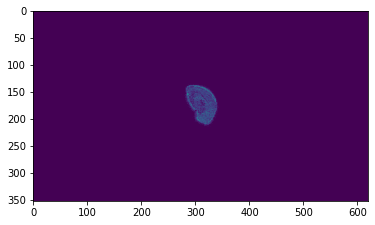

In [ ]:
plt.imshow(padded_imgs[1500])

Картинки разных размеров!!! Прям очень разных. Как бороться?...

Пробую пэддинг, но выглядит странно.
Наверное, нужно брать батчи.

### Unfold

In [ ]:
t_im1 = torch.Tensor(imgs[50]).view([1, 1, 178, 156])

In [ ]:
t_im2 = torch.Tensor(imgs[100]).unsqueeze(0).unsqueeze(0)

In [ ]:
t_im2.shape

torch.Size([1, 1, 50, 50])

In [ ]:
unfold = nn.Unfold(kernel_size = 32)

In [ ]:
un1 = unfold(t_im1)
un2 = unfold(t_im2)
un3 = unfold(full_tensor1)

In [ ]:
patches = x.unfold(1, size, stride).unfold(2, size, stride).unfold(3, size, stride)


In [ ]:
un1.shape

torch.Size([1, 1024, 18375])

In [ ]:
un2.shape

torch.Size([1, 1024, 361])

In [ ]:
un3.shape

torch.Size([1, 7168, 3776])

In [ ]:
ch_n[0]

7

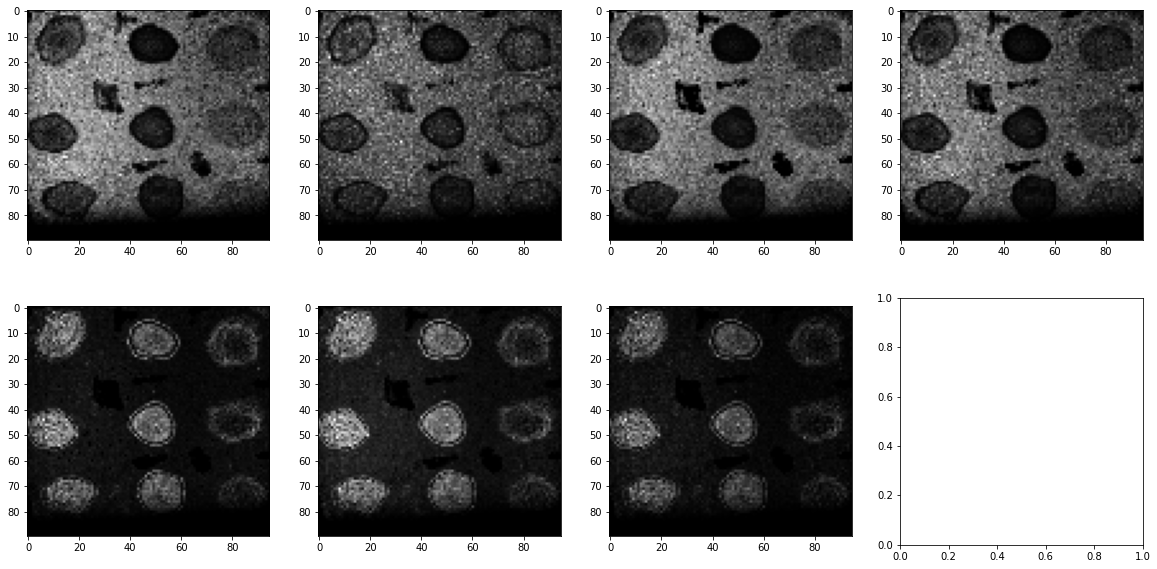

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows = 2, figsize=(20, 10))
for i in range(ch_n[0]):
  ax[i//4, i%4].imshow(imgs[i], cmap = 'gray')

In [ ]:
ch_n[2]

11

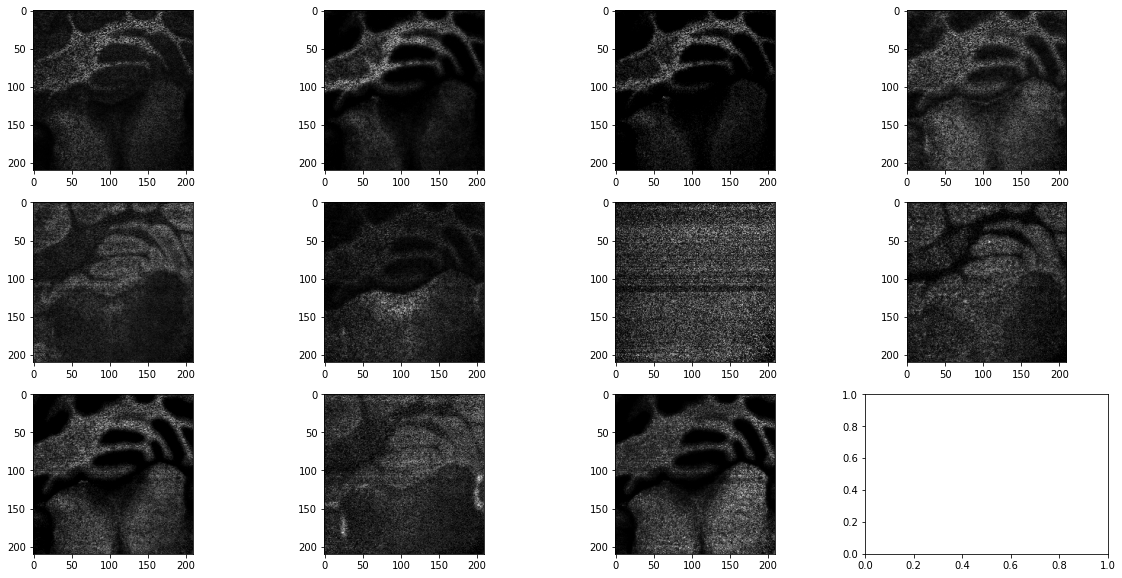

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows = 3, figsize=(20, 10))
for i in range(ch_n[1]):
  ax[i//4, i%4].imshow(imgs[ch_n[0]+i], cmap = 'gray')

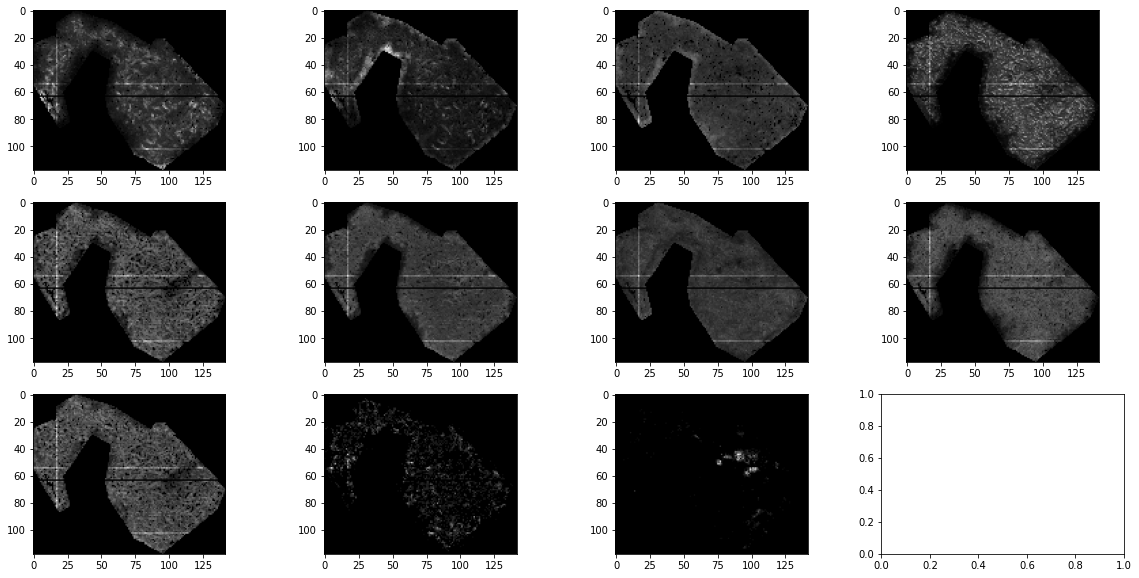

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows = 3, figsize=(20, 10))
for i in range(ch_n[2]):
  ax[i//4, i%4].imshow(imgs[ch_n[0] + ch_n[1] + i], cmap = 'gray')

In [ ]:
full_tensor1 = torch.Tensor(imgs[:ch_n[0]]).unsqueeze(0)

In [ ]:
full_tensor1.shape

torch.Size([1, 7, 90, 95])

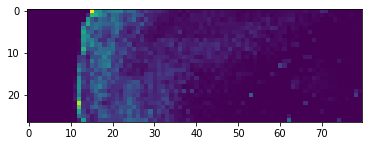

In [ ]:
plt.imshow(imgs[1077])

In [ ]:
a = 0
patches_tensor = []

kh, kw = 16, 16  # kernel size
dh, dw = 16, 16  # stride

for i in range(n_datas):
  t_img = torch.Tensor(imgs[a: a + ch_n[i]]).unsqueeze(0)
  kc = t_img.shape[1]
  dc = kc

  patches = t_img.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
  unfold_shape = patches.size()
  patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)

  a += ch_n[i]
  patches_tensor.append(patches.squeeze(0))

In [ ]:
patches_tensor[0].shape

torch.Size([25, 7, 16, 16])

In [ ]:
patches_shapes = [i.shape for i in patches_tensor]

In [ ]:
patches_shapes_P = [i.shape[0] for i in patches_tensor]

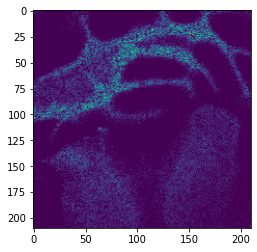

In [ ]:
plt.imshow(imgs[9])

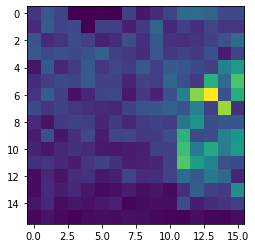

In [ ]:
plt.imshow(patches_tensor[0][-1][6].numpy())

In [ ]:
patches_shapes

[torch.Size([25, 7, 16, 16]),
 torch.Size([169, 11, 16, 16]),
 torch.Size([56, 11, 16, 16]),
 torch.Size([90, 9, 16, 16]),
 torch.Size([20, 10, 16, 16]),
 torch.Size([99, 9, 16, 16]),
 torch.Size([40, 11, 16, 16]),
 torch.Size([45, 11, 16, 16]),
 torch.Size([196, 11, 16, 16]),
 torch.Size([40, 10, 16, 16]),
 torch.Size([9, 11, 16, 16]),
 torch.Size([78, 9, 16, 16]),
 torch.Size([90, 11, 16, 16]),
 torch.Size([15, 11, 16, 16]),
 torch.Size([240, 11, 16, 16]),
 torch.Size([35, 9, 16, 16]),
 torch.Size([48, 11, 16, 16]),
 torch.Size([9, 10, 16, 16]),
 torch.Size([16, 11, 16, 16]),
 torch.Size([9, 10, 16, 16]),
 torch.Size([12, 11, 16, 16]),
 torch.Size([112, 19, 16, 16]),
 torch.Size([56, 11, 16, 16]),
 torch.Size([35, 17, 16, 16]),
 torch.Size([110, 19, 16, 16]),
 torch.Size([108, 9, 16, 16]),
 torch.Size([35, 11, 16, 16]),
 torch.Size([6, 11, 16, 16]),
 torch.Size([12, 11, 16, 16]),
 torch.Size([18, 11, 16, 16]),
 torch.Size([154, 11, 16, 16]),
 torch.Size([20, 17, 16, 16]),
 torch.Size

In [ ]:
from collections import Counter

In [ ]:
Counter(patches_shapes_P)

Counter({1: 1,
         2: 5,
         3: 1,
         4: 5,
         5: 1,
         6: 4,
         8: 2,
         9: 22,
         10: 3,
         12: 9,
         14: 1,
         15: 5,
         16: 14,
         18: 4,
         20: 11,
         21: 2,
         24: 6,
         25: 14,
         28: 4,
         30: 10,
         32: 2,
         35: 6,
         36: 10,
         40: 6,
         42: 8,
         45: 2,
         48: 7,
         49: 3,
         50: 4,
         51: 1,
         54: 4,
         55: 1,
         56: 7,
         60: 4,
         64: 1,
         66: 3,
         70: 1,
         72: 2,
         77: 1,
         78: 1,
         81: 3,
         84: 1,
         88: 1,
         90: 3,
         91: 1,
         96: 1,
         98: 2,
         99: 2,
         105: 3,
         108: 2,
         110: 2,
         112: 3,
         120: 3,
         121: 2,
         135: 1,
         136: 2,
         144: 5,
         150: 1,
         154: 2,
         160: 3,
         169: 2,
         180:

In [ ]:
patches_shapes_P = list(set(patches_shapes_P))

In [ ]:
for i in range(5):
  print(patches_tensor[i].shape)

torch.Size([25, 6, 16, 16])
torch.Size([169, 6, 16, 16])
torch.Size([56, 6, 16, 16])
torch.Size([90, 6, 16, 16])
torch.Size([20, 6, 16, 16])


In [ ]:
all_patches = torch.cat(patches_tensor, dim = 0)

In [ ]:
all_patches.shape

torch.Size([21699, 6, 16, 16])

In [ ]:
import random
r_ind = random.sample(range(21699), 12)

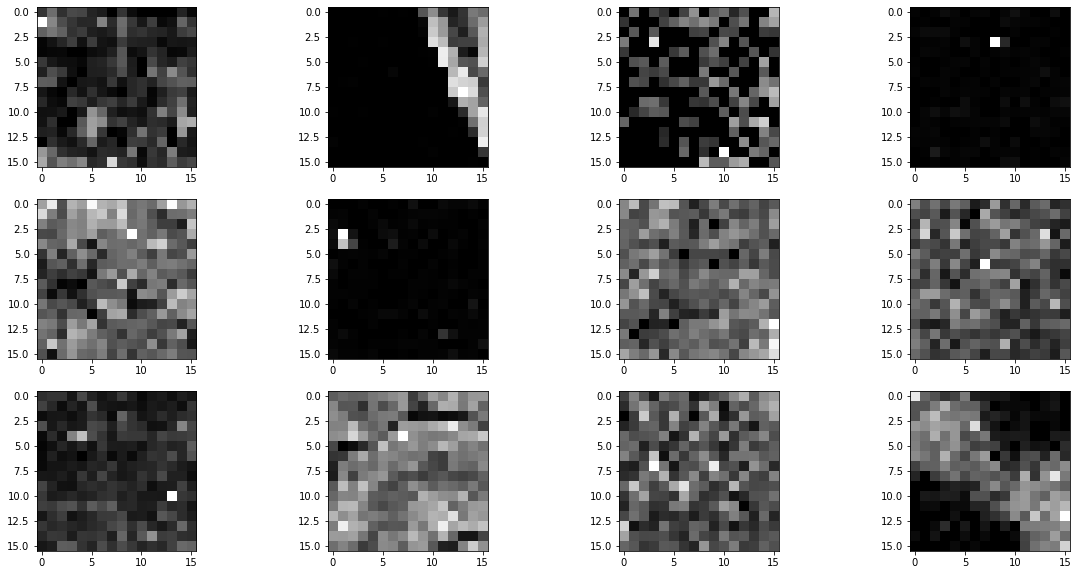

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows = 3, figsize=(20, 10))
for i in range(12):
  ind = r_ind[i]
  ax[i//4, i%4].imshow(all_patches[ind][5].numpy(), cmap = 'gray')

In [ ]:
kc, kh, kw = 7, 30, 30  # kernel size
dc, dh, dw = 7, 30, 30  # stride
patches = full_tensor1.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
print(patches.shape)

NameError: ignored

In [ ]:
pp = patches.view(-1, 30,30)

In [ ]:
pp.shape

torch.Size([63, 30, 30])

In [ ]:
patches[0][0][0].shape

torch.Size([32, 32])

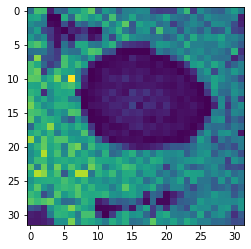

In [ ]:
plt.imshow(patches[0][1][0].numpy())

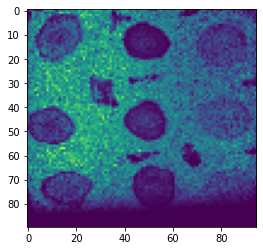

In [ ]:
plt.imshow(imgs[0])

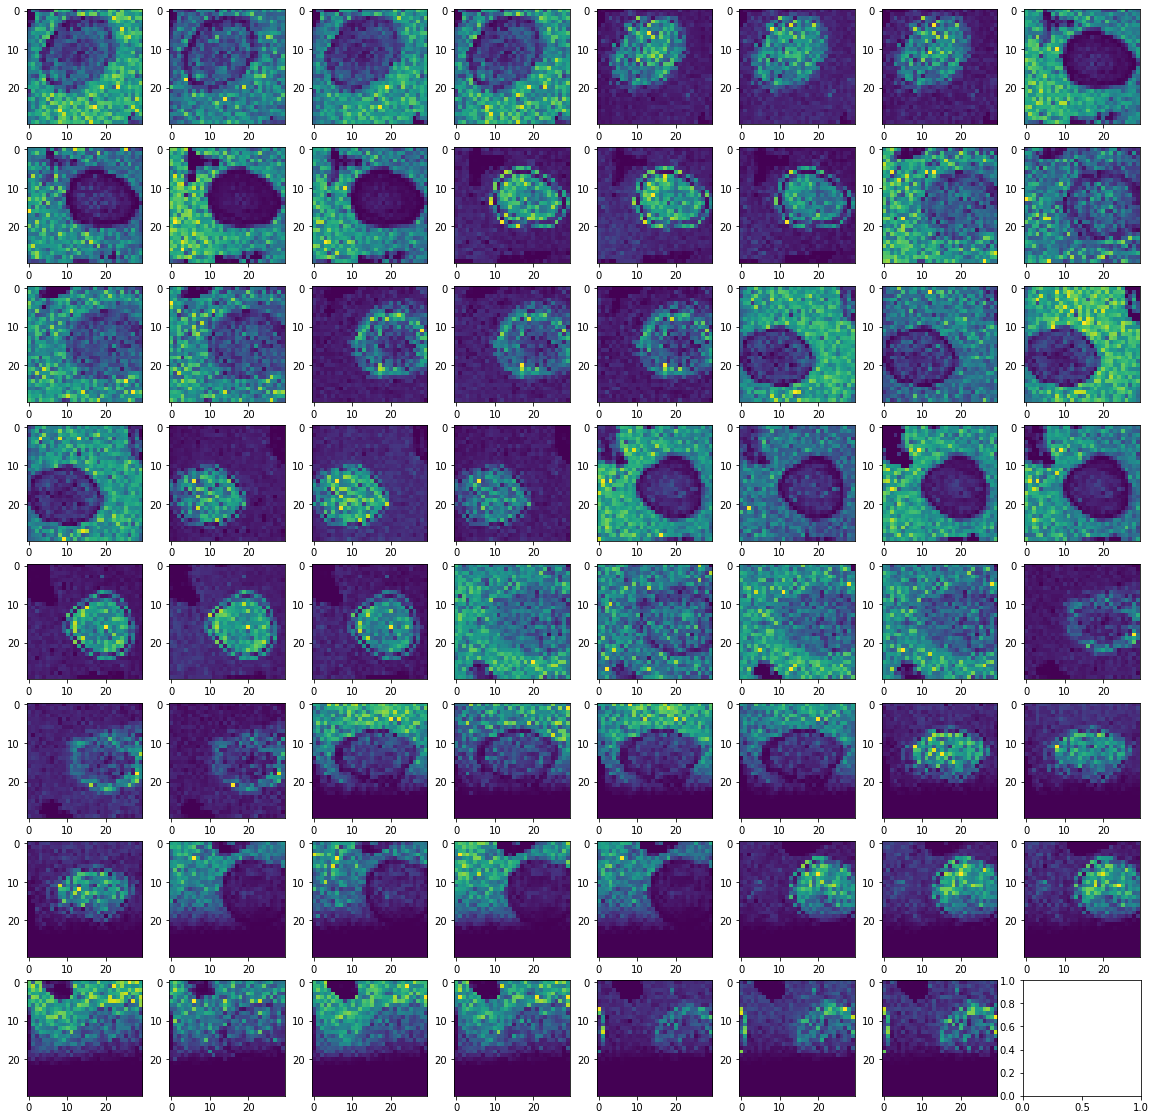

In [ ]:
fig, ax = plt.subplots(ncols=8, nrows = 8, figsize=(20, 20))
for i in range(63):
  ax[i//8, i%8].imshow(pp[i])#, cmap = 'gray')

## Normal one

In [ ]:
class VCN(nn.Module):
    def __init__(self):
        super(VCN, self).__init__()

        self.conv = и

    def conv_complex():
        conv_complex = nn.Sequential


Вопросы:


нормировать или нет?

как засунуть картинки без ресайзинга и без пэддинга

как нормировать?????? у меня же не просто пиксели.....

## slicing check

In [ ]:
indices_all[0]

[[0, 1091], [0, 203], [0, 1318], [0, 178], [0, 1020], [0, 566], [0, 1442]]

In [ ]:
a0 = s[0][1091].to_dense()[:25].unsqueeze(0)
a1 = s[0][203].to_dense()[:25].unsqueeze(0)
a2 = s[0][1318].to_dense()[:25].unsqueeze(0)
a3 = s[0][178].to_dense()[:25].unsqueeze(0)
a4 = s[0][1020].to_dense()[:25].unsqueeze(0)
a5 = s[0][566].to_dense()[:25].unsqueeze(0)
a6 = s[0][1442].to_dense()[:25].unsqueeze(0)


In [ ]:
a = torch.cat([a0,a1,a2,a3,a4,a5,a6],0)

In [ ]:
a.shape

torch.Size([7, 25, 16, 16])

In [ ]:
patches = a
unfold_shape = shapes_list[0]

patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

In [ ]:
patches_orig.shape

torch.Size([1, 7, 80, 80])

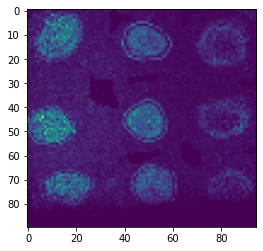

In [ ]:
plt.imshow(imgs[6])

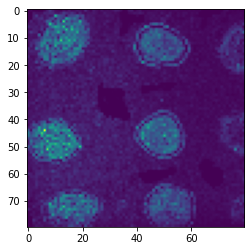

In [ ]:
plt.imshow(patches_orig[0][6])

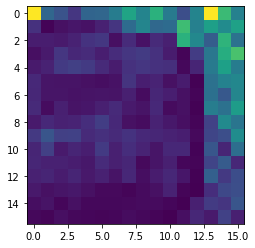

In [ ]:
plt.imshow(s[0][1442][1])

In [ ]:
s.shape

torch.Size([2, 1661, 169, 16, 16])

In [ ]:
#s = torch.sparse_coo_tensor(list(zip(*indices_all[0])), patches_tensor_sparse[0], (1, len(chem_dict.keys()), 25, 16, 16))

In [ ]:
len(chem_dict.keys())

1661